In [5]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [6]:
import torch
import library
import sindy
from neuromancer import psl
from torch.utils.data import DataLoader
from matplotlib.lines import Line2D
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.plot import pltOL
import matplotlib.pyplot as plt
import itertools

torch.manual_seed(0)
# For now, we use CPU till we fix the cuda utilization error
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Plotting Open Loop System

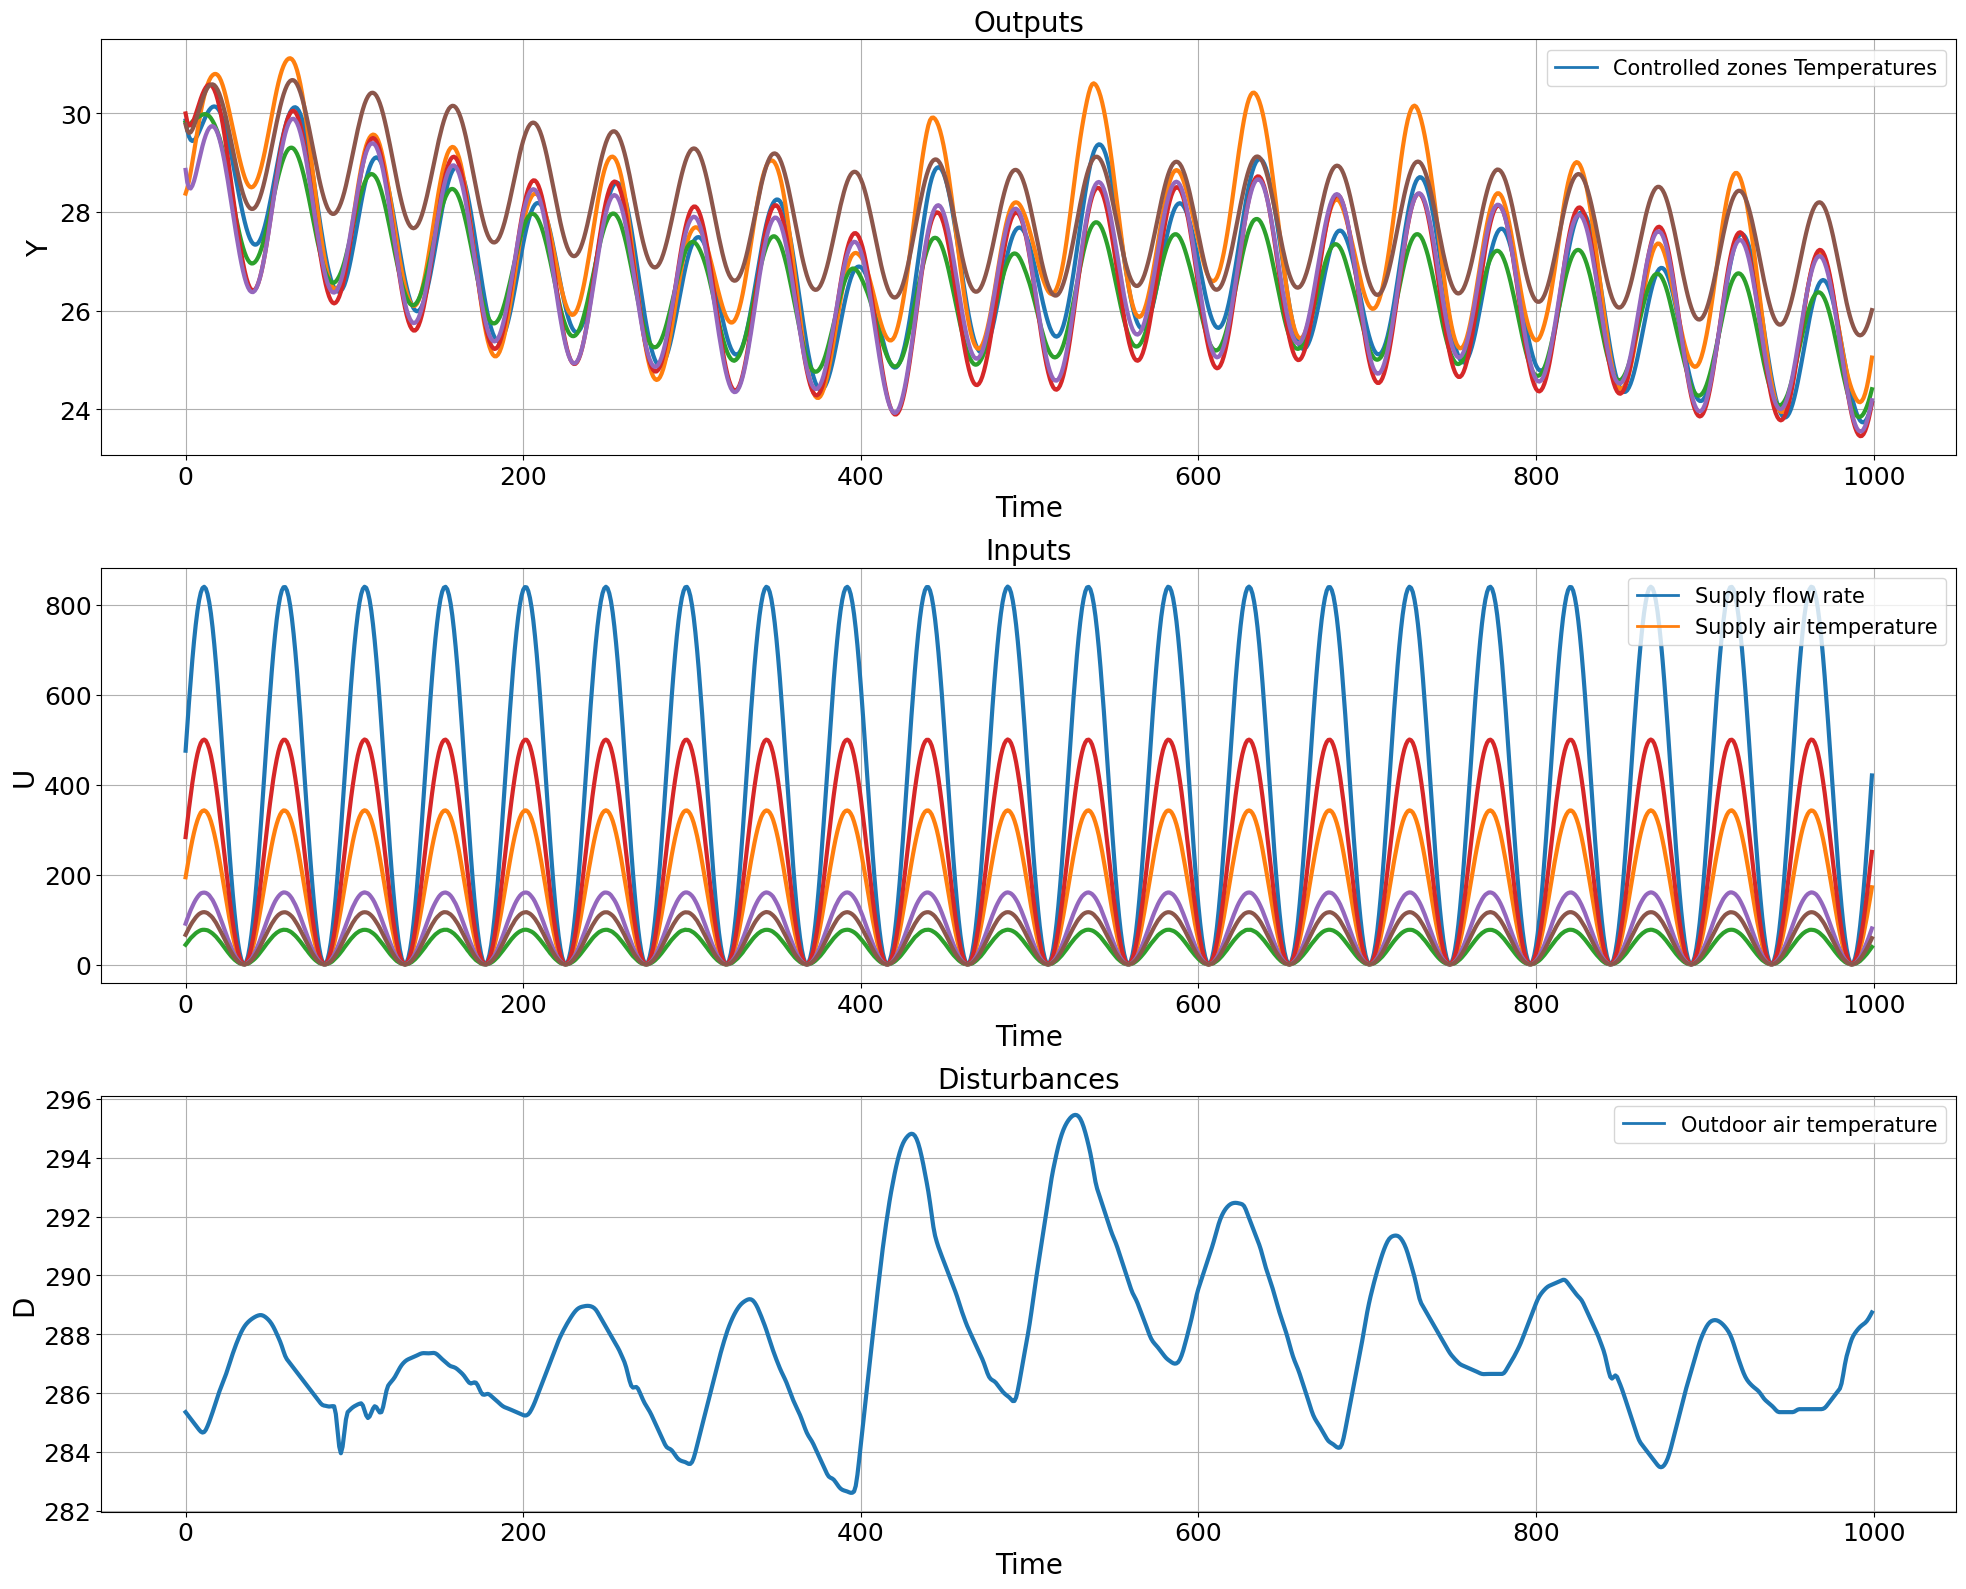

In [7]:
gt_model_name = "LinearReno_ROM40"
gt_model = psl.systems[gt_model_name]()

ts = gt_model.ts
nx = gt_model.nx
ny = gt_model.ny
nu = gt_model.nu
nd = gt_model.nd

raw = gt_model.simulate(nsim=1000)
fig, ax = pltOL(Y=raw['Y'], U=raw['U'], D=raw['D'])
# add custom legends to plots
custom_lines_1 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-')]
custom_lines_2 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-'),
                    Line2D([0], [0], color='tab:orange', lw=2, linestyle='-')]
ax[0, 0].legend(custom_lines_1, ['Controlled zones Temperatures'], fontsize=15, loc="best")
ax[1, 0].legend(custom_lines_2, ['Supply flow rate', 'Supply air temperature'], fontsize=15, loc="best")
ax[2, 0].legend(custom_lines_1, ['Outdoor air temperature'], fontsize=15, loc="best")

### Getting the Training Data

In [8]:
def normalize(x, mean, std):
    return (x - mean) / std

def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nd = sys.nd
    ny = sys.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    mean_x = gt_model.stats['X']['mean']
    std_x = gt_model.stats['X']['std']
    mean_y = gt_model.stats['Y']['mean']
    std_y = gt_model.stats['Y']['std']
    mean_u = gt_model.stats['U']['mean']
    std_u = gt_model.stats['U']['std']
    mean_d = gt_model.stats['D']['mean']
    std_d = gt_model.stats['D']['std']

    trainX = normalize(train_sim['X'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainY = normalize(train_sim['Y'][:length], mean_y, std_y)
    trainY = trainY.reshape(nbatch, nsteps, ny)
    trainY = torch.tensor(trainY, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    trainD = normalize(train_sim['D'][:length], mean_d, std_d)
    trainD = trainD.reshape(nbatch, nsteps, nd)
    trainD = torch.tensor(trainD, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'yn': trainY[:, 0:1, :],
                              'Y': trainY,
                              'U': trainU,
                              'D': trainD}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = normalize(dev_sim['X'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devY = normalize(dev_sim['Y'][:length], mean_y, std_y)
    devY = devY.reshape(nbatch, nsteps, ny)
    devY = torch.tensor(devY, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    devD = normalize(dev_sim['D'][:length], mean_d, std_d)
    devD = devD[:length].reshape(nbatch, nsteps, nd)
    devD = torch.tensor(devD, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'yn': devY[:, 0:1, :],
                            'Y': devY,
                            'U': devU,
                            'D': devD}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = normalize(test_sim['X'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testY = normalize(test_sim['Y'][:length], mean_y, std_y)
    testY = testY.reshape(1, nbatch*nsteps, ny)
    testY = torch.tensor(testY, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch * nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    testD = normalize(test_sim['D'][:length], mean_d, std_d)
    testD = testD.reshape(1, nbatch*nsteps, nd)
    testD = torch.tensor(testD, dtype=torch.float32)
    test_data = {'X': testX, 'yn': testY[:, 0:1, :],
                 'Y': testY, 'U': testU, 'D': testD,
                 'name': 'test'}

    return train_loader, dev_loader, test_data

In [9]:
def update_nsteps_all(train_loader, dev_loader, new_nsteps, batch_size):
    """
    Updates the time sequence length (nsteps) for train, dev, and test datasets.

    :param train_loader: (DataLoader) Original train DataLoader
    :param dev_loader: (DataLoader) Original dev DataLoader
    :param test_data: (dict) Original test dataset
    :param new_nsteps: (int) New sequence length
    :param batch_size: (int) Batch size for the new DataLoaders

    :return: (DataLoader, DataLoader, dict) Updated train_loader, dev_loader, and test_data
    """

    def reshape_data(tensor, new_nsteps):
        """ Ensures the tensor is sliced properly and reshaped safely """
        total_elements = tensor.shape[0] * tensor.shape[1]  # Compute total available elements
        nbatch = total_elements // new_nsteps  # Compute new number of batches
        length = nbatch * new_nsteps  # Ensure full sequences

        return torch.flatten(tensor, 0, 1)[:length].reshape(nbatch, new_nsteps, tensor.shape[-1])

    def process_loader(loader, name):
        """
        Extracts data from a DataLoader, reshapes it with new_nsteps, and returns a new DataLoader.
        """
        datadict = loader.dataset.datadict

        # Reshape data with new_nsteps
        newX = reshape_data(datadict["X"], new_nsteps)
        newY = reshape_data(datadict["Y"], new_nsteps)
        newU = reshape_data(datadict["U"], new_nsteps)
        newD = reshape_data(datadict["D"], new_nsteps)

        # Create new dataset
        new_data = DictDataset({'X': newX, 'yn': newY[:, 0:1, :], 'Y': newY, 'U': newU, 'D': newD}, name=name)

        # Create new DataLoader
        new_loader = DataLoader(new_data, batch_size=batch_size, collate_fn=new_data.collate_fn, shuffle=True)
        return new_loader

    # Process train and dev loaders
    new_train_loader = process_loader(train_loader, "train")
    new_dev_loader = process_loader(dev_loader, "dev")

    return new_train_loader, new_dev_loader




In [86]:
nsteps_list = [2,8,20,30,40,60]

In [87]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = nsteps_list[0] # number of prediction horizon steps in the loss function
bs = 100       # minibatching batch size
train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)



### Function Libraries

In [88]:
# import itertools
# max_degree = 3
# max_freq = 3
#
# theta_1 = library.FourierLibrary(ny, nu+nd, max_freq=max_freq, include_cos=True)
# theta_2 = library.PolynomialLibrary(ny, nu+nd, max_degree=max_degree, interaction=True)
#
# fx = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2]))
# print(fx)

In [89]:

from library import FunctionLibrary

# Number of features and control variables
n_features = ny
n_controls = nu + nd

# Create an empty list for features and names
theta_funs = []
theta_names = []

# Degree 1 features (x_i)
theta_funs += [(lambda X, u, i=i: X[:, i]) for i in range(n_features)]
theta_names += [f"x_{i}" for i in range(n_features)]

# Sinusoidal features (sin(x_i))
theta_funs += [(lambda X, u, i=i: torch.sin(X[:, i])) for i in range(n_features)]
theta_names += [f"sin(x_{i})" for i in range(n_features)]

# # Product of x_i and sin(x_i)
# theta_funs += [(lambda X, u, i=i: X[:, i] * torch.sin(X[:, i])) for i in range(n_features)]
# theta_names += [f"x_{i} * sin(x_{i})" for i in range(n_features)]

#Quadratic interaction terms (x_i * x_j)
for i, j in itertools.combinations(range(n_features), 2):
    theta_funs.append(lambda X, u, i=i, j=j: X[:, i] * X[:, j])
    theta_names.append(f"x_{i} * x_{j}")


# Control inputs (u_i)
theta_funs += [(lambda X, u, i=i: u[:, i]) for i in range(n_controls)]
theta_names += [f"u_{i}" for i in range(n_controls)]

# Squared control inputs (u_i^2)
theta_funs += [(lambda X, u, i=i: u[:, i] ** 2) for i in range(n_controls)]
theta_names += [f"u_{i}^2" for i in range(n_controls)]

# Interaction terms (x_i * u_j)
theta_funs += [(lambda X, u, i=i, j=j: X[:, i] * u[:, j]) for i in range(n_features) for j in range(n_controls)]
theta_names += [f"x_{i} * u_{j}" for i in range(n_features) for j in range(n_controls)]

# Create function library
theta_library = FunctionLibrary(theta_funs, n_features, n_controls, theta_names)


# Create SINDy model
fx = sindy.SINDy(theta_library)
print(fx)


dx0/dt = 0.602*x_0 + 0.366*x_1 + 0.303*x_2 + 0.780*x_3 + 0.317*x_4 + 0.697*x_5 + 0.349*sin(x_0) + 0.286*sin(x_1) + 0.081*sin(x_2) + 0.562*sin(x_3) + 0.526*sin(x_4) + 0.149*sin(x_5) + 0.384*x_0 * x_1 + 0.146*x_0 * x_2 + 0.950*x_0 * x_3 + 0.887*x_0 * x_4 + 0.230*x_0 * x_5 + 0.854*x_1 * x_2 + 0.846*x_1 * x_3 + 0.304*x_1 * x_4 + 0.103*x_1 * x_5 + 0.308*x_2 * x_3 + 0.665*x_2 * x_4 + 0.388*x_2 * x_5 + 0.044*x_3 * x_4 + 0.275*x_3 * x_5 + 0.967*x_4 * x_5 + 0.024*u_0 + 0.274*u_1 + 0.698*u_2 + 0.597*u_3 + 0.738*u_4 + 0.331*u_5 + 0.396*u_6 + 0.934*u_0^2 + 0.510*u_1^2 + 0.286*u_2^2 + 0.625*u_3^2 + 0.787*u_4^2 + 0.551*u_5^2 + 0.257*u_6^2 + 0.481*x_0 * u_0 + 0.291*x_0 * u_1 + 0.426*x_0 * u_2 + 0.524*x_0 * u_3 + 0.926*x_0 * u_4 + 0.512*x_0 * u_5 + 0.585*x_0 * u_6 + 0.725*x_1 * u_0 + 0.184*x_1 * u_1 + 0.295*x_1 * u_2 + 0.805*x_1 * u_4 + 0.297*x_1 * u_5 + 0.297*x_1 * u_6 + 0.452*x_2 * u_0 + 0.700*x_2 * u_1 + 0.025*x_2 * u_2 + 0.571*x_2 * u_3 + 0.571*x_2 * u_4 + 0.097*x_2 * u_5 + 0.173*x_2 * u_6 + 0.462

### Creating the Nodes and System

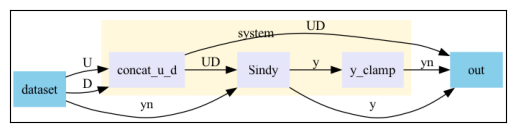

In [90]:
integrator = integrators.Euler(fx, h=ts)
combined_ud = Node(lambda u, d: torch.cat([u, d], dim=-1),
              ['U', 'D'], ['UD'], name="concat_u_d")

integrator_node = Node(integrator, ['yn', 'UD'], ['y'], name="Sindy")
y_bound = Node(lambda x: torch.clamp(x, -20., 20.), ['y'], ['yn'], "y_clamp")
dynamics_model = System([combined_ud, integrator_node, y_bound], name="dynamics_model")
dynamics_model.show()


In [91]:
# %% Constraints + losses:
y = variable("Y")
yhat = variable('yn')[:,:-1,:]

# trajectory tracking loss
reference_loss = 5.*(yhat == y)^2
reference_loss.name = "ref_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

#sparsity
l1 = variable([y], lambda y: torch.norm(list(fx.parameters())[0]))
l2 = variable([y], lambda y: torch.norm(list(fx.parameters())[0], p=2))

l1_weight = [0. ,0.0001, 0.001, 0.01, 0.1, 0.1]
loss_l1 = l1_weight[0]*(l1 == 0)
loss_l1.name= "l1_loss"

# loss_l2 = l1_weight[0]*(l2 == 0)
# loss_l2.name= "l2_loss"


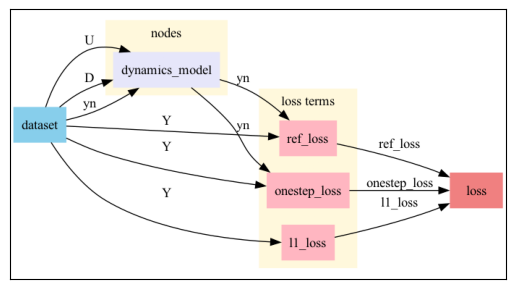

In [92]:

# putting things together
#nodes = [encode_sym, dynamics_model]
objectives = [reference_loss, onestep_loss, loss_l1]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem([dynamics_model], loss)
# plot computational graph
problem.show()

### Training the SINDy Model

In [93]:
optimizer = torch.optim.AdamW(problem.parameters(),
                                lr=.005)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=300,
    epochs=20000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
    lr_scheduler=True,
    
)


None
Number of parameters: 498


In [94]:
# best_model = trainer.train()
# trainer.model.load_state_dict(best_model)

In [95]:
# Curriculum Model training
iterations = len(nsteps_list)+1
for i in range(1,iterations):
    print(f'training with {nsteps} steps')
    best_model = trainer.train()
    trainer.model.load_state_dict(best_model)
    nsteps = nsteps_list[i]  # increase prediction horizon

    # trainer.model.loss.objectives[2].weight, trainer.model.loss.objectives[3].weight = l1_weight[i], l1_weight[i]
    trainer.model.loss.objectives[2].weight = l1_weight[i]
    # create dataloaders with batched trajectories using new prediction horizon
    train_loader, dev_loader , test_data = \
        get_data(gt_model, nsim, nsteps, ts, bs)
    trainer.train_data, trainer.dev_data, trainer.test_data = \
        train_loader, dev_loader, test_data
    # reset early stopping
    trainer.badcount = 0

training with 2 steps
epoch: 0	train_loss: 0.12201	dev_loss: 0.07617	eltime:  1.18488
epoch: 1	train_loss: 0.10780	dev_loss: 0.08012	eltime:  1.24410
epoch: 2	train_loss: 0.07607	dev_loss: 0.08337	eltime:  1.29663
epoch: 3	train_loss: 0.05858	dev_loss: 0.04473	eltime:  1.34684
epoch: 4	train_loss: 0.04404	dev_loss: 0.02457	eltime:  1.39919
epoch: 5	train_loss: 0.04018	dev_loss: 0.03158	eltime:  1.45252
epoch: 6	train_loss: 0.02698	dev_loss: 0.02773	eltime:  1.50522
epoch: 7	train_loss: 0.01868	dev_loss: 0.01542	eltime:  1.55657
epoch: 8	train_loss: 0.01847	dev_loss: 0.02121	eltime:  1.60737
epoch: 9	train_loss: 0.01170	dev_loss: 0.01577	eltime:  1.65767
epoch: 10	train_loss: 0.01315	dev_loss: 0.01899	eltime:  1.70758
epoch: 11	train_loss: 0.01213	dev_loss: 0.01654	eltime:  1.75643
epoch: 12	train_loss: 0.00828	dev_loss: 0.01226	eltime:  1.80980
epoch: 13	train_loss: 0.01019	dev_loss: 0.01316	eltime:  1.85892
epoch: 14	train_loss: 0.00878	dev_loss: 0.01338	eltime:  1.90757
epoch: 15	tra

IndexError: list index out of range

In [96]:
print(fx)

dx0/dt = -4.632*x_0 + -1.157*x_1 + 1.575*x_2 + -2.158*x_3 + 1.115*x_4 + 0.940*x_5 + -3.603*sin(x_0) + -0.452*sin(x_1) + 3.198*sin(x_2) + -1.198*sin(x_3) + 0.713*sin(x_4) + 1.901*sin(x_5) + 0.505*x_0 * x_1 + 0.727*x_0 * x_2 + 1.992*x_0 * x_3 + 0.365*x_0 * x_4 + 1.522*x_0 * x_5 + -0.392*x_1 * x_2 + 0.063*x_1 * x_3 + -1.667*x_1 * x_4 + -0.654*x_1 * x_5 + 0.019*x_2 * x_3 + -1.264*x_2 * x_4 + -0.505*x_2 * x_5 + -1.112*x_3 * x_4 + 0.562*x_3 * x_5 + -0.796*x_4 * x_5 + 0.695*u_0 + 0.884*u_1 + 1.160*u_2 + 1.118*u_3 + 1.218*u_4 + 0.909*u_5 + 3.887*u_6 + 0.216*u_0^2 + -0.092*u_1^2 + -0.267*u_2^2 + -0.018*u_3^2 + 0.112*u_4^2 + -0.070*u_5^2 + -0.521*u_6^2 + -0.086*x_0 * u_0 + -0.231*x_0 * u_1 + -0.103*x_0 * u_2 + -0.055*x_0 * u_3 + 0.247*x_0 * u_4 + -0.047*x_0 * u_5 + 1.035*x_0 * u_6 + 0.089*x_1 * u_0 + -0.316*x_1 * u_1 + -0.209*x_1 * u_2 + -0.450*x_1 * u_3 + 0.150*x_1 * u_4 + -0.221*x_1 * u_5 + -0.529*x_1 * u_6 + -0.145*x_2 * u_0 + 0.038*x_2 * u_1 + -0.445*x_2 * u_2 + -0.056*x_2 * u_3 + -0.053*x_2

### Closed Loop System Rollout

In [97]:
# update the rollout length based on the test data
with torch.no_grad():
    #dynamics_model.nsteps = test_data['Y'].shape[1]
    test_output = dynamics_model(test_data)

def denormalize(x, mean, std):
    return (x * std) + mean

pred_traj = denormalize(test_output['yn'][:, :-1, :], gt_model.stats["Y"]["mean"], gt_model.stats["Y"]["std"]).reshape(-1, ny).T
true_traj = denormalize(test_data['Y'], gt_model.stats["Y"]["mean"], gt_model.stats["Y"]["std"]).reshape(-1, ny).T


In [104]:
test_output = dynamics_model(test_data)
torch.nn.functional.mse_loss(test_output['yn'], test_data['Y']).item()

529.87890625

In [105]:
test_output['Y'].shape

torch.Size([1, 1980, 6])

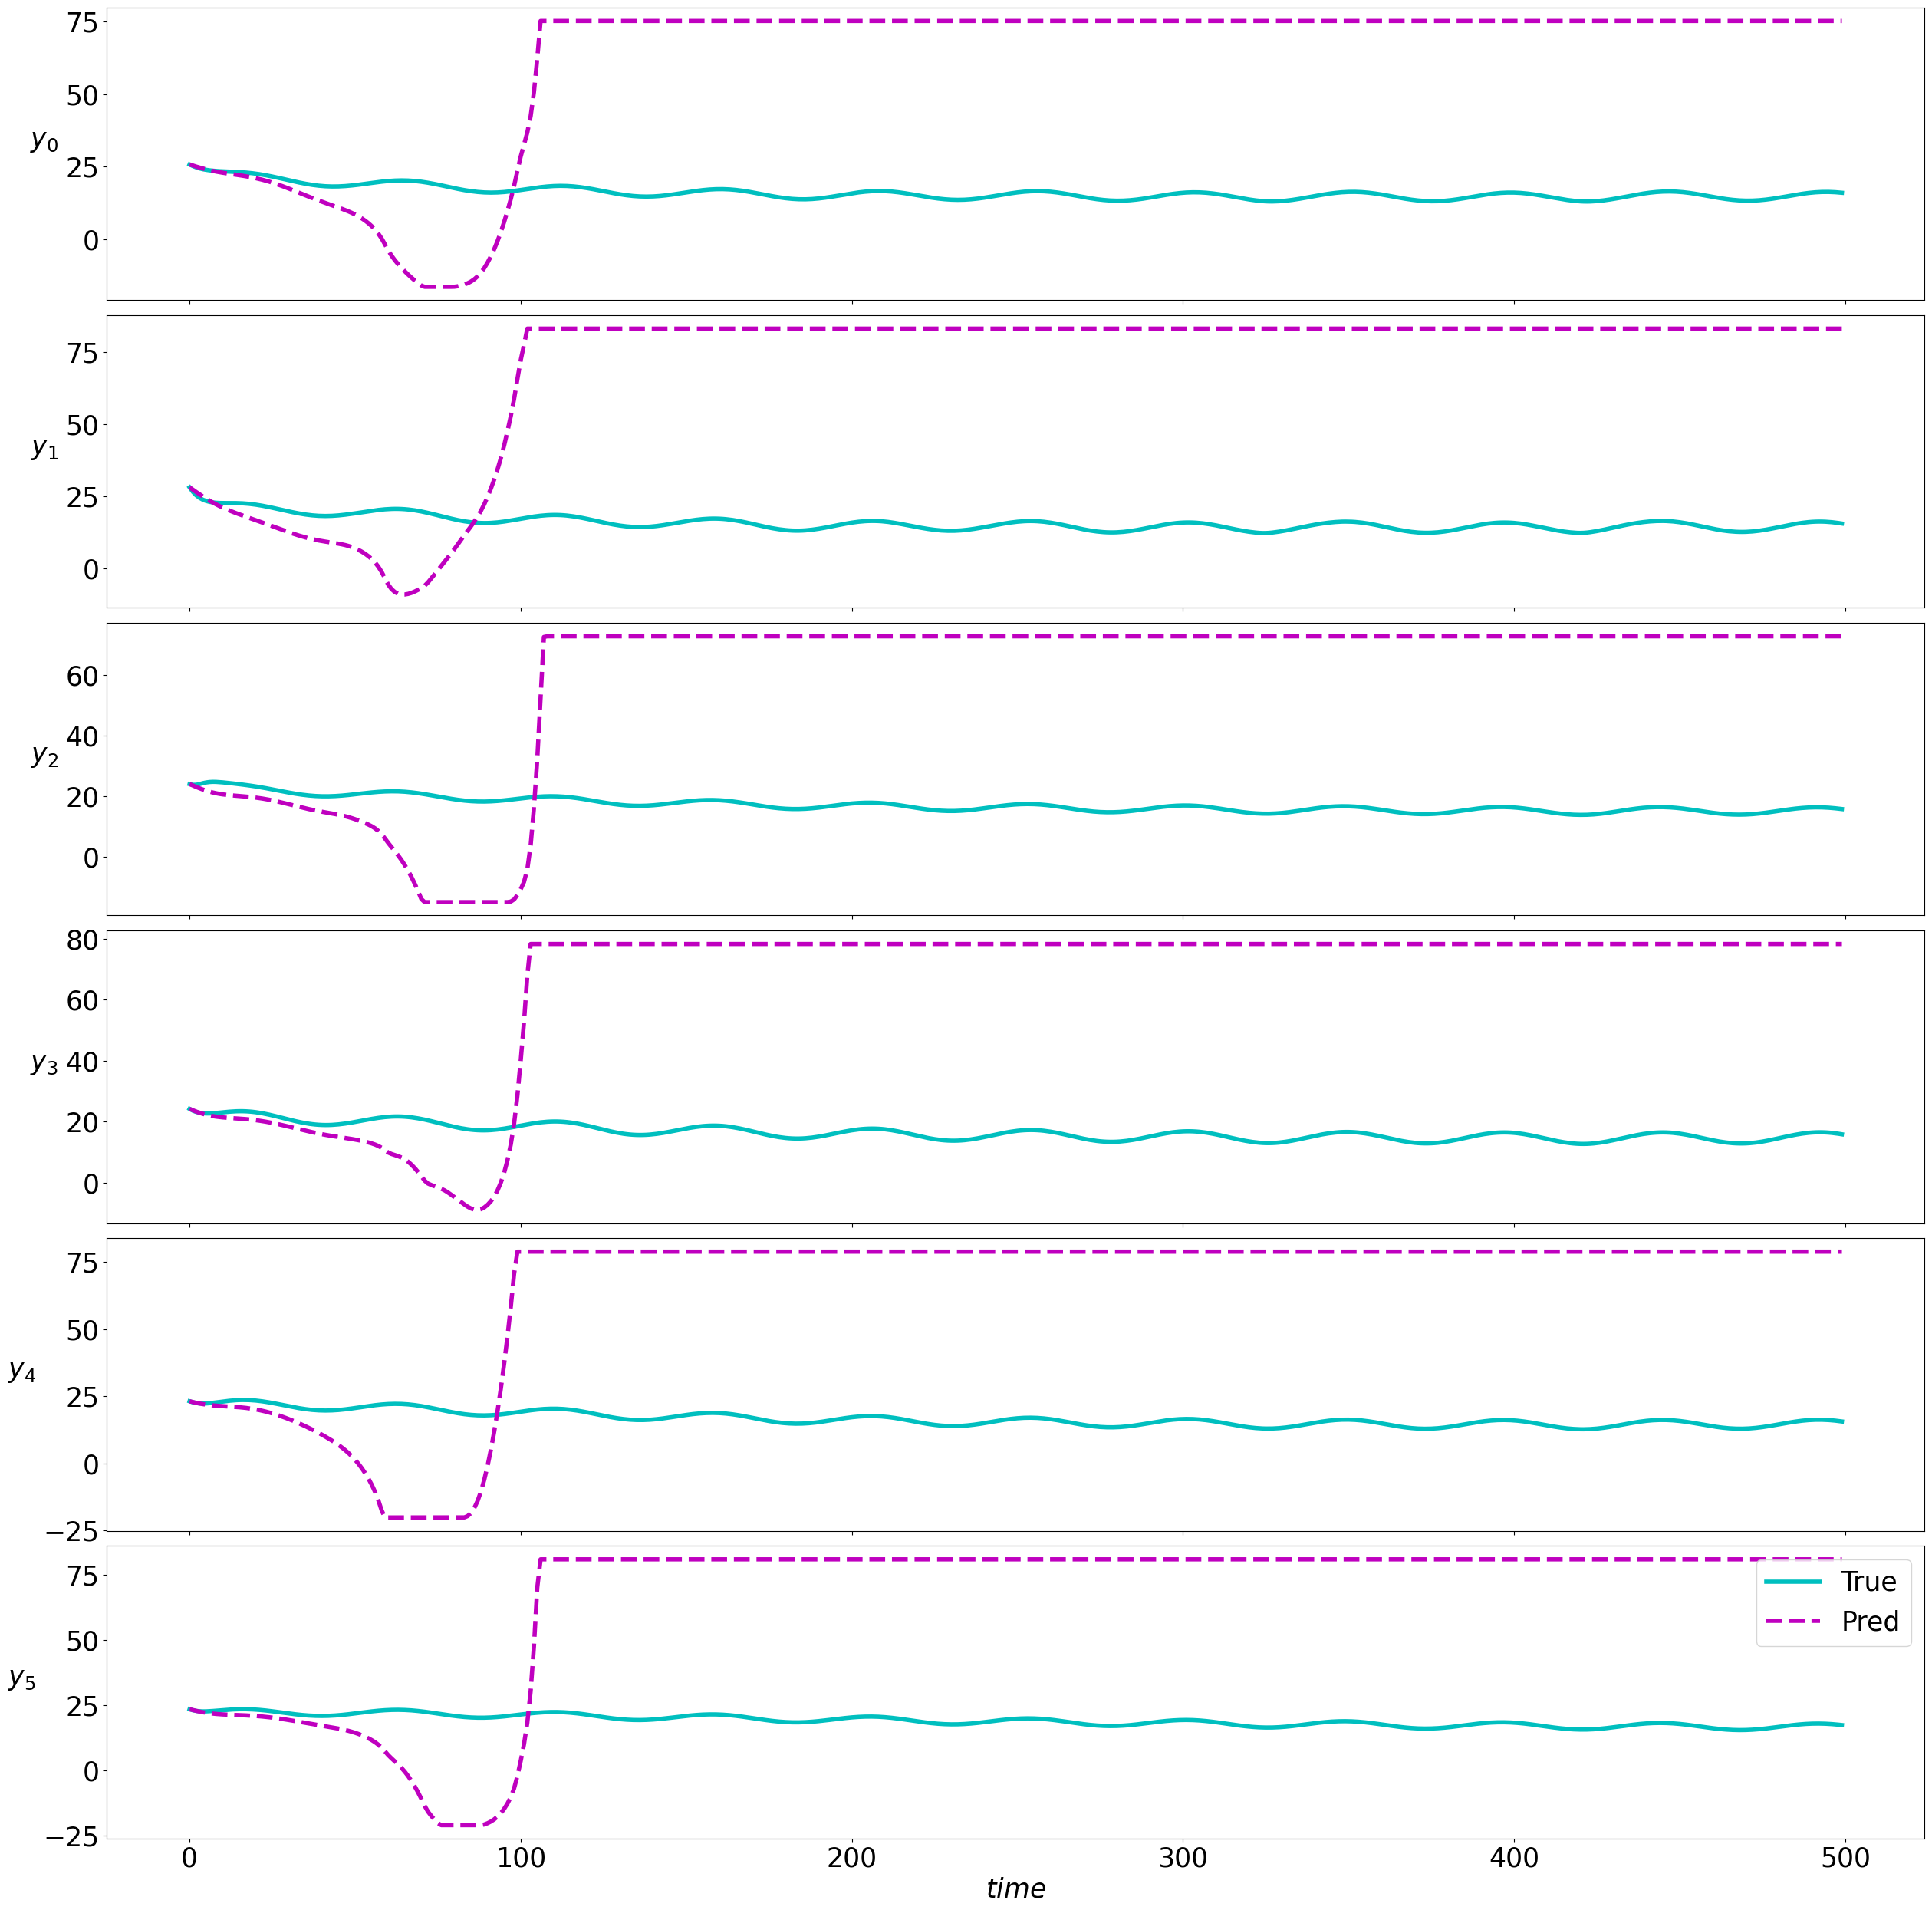

In [85]:

plt_nsteps = 500
figsize = 25
fig, ax = plt.subplots(ny, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if ny > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:plt_nsteps], 'c', linewidth=4.0, label='True')
    axe.plot(t2[:plt_nsteps], 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()